In [1]:
from __future__ import division, print_function
import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
from importlib import reload  # Python 3
import utils; reload(utils)

import time
from utils import pred_batch
from utils import plots
from utils import confusion_matrix
from utils import plot_confusion_matrix
from utils import get_batches

from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, ZeroPadding2D  # Conv2D: Keras2
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations


%matplotlib inline

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 970 (CNMeM is enabled with initial size: 80.0% of memory, cuDNN 5110)
Using Theano backend.


# Define constants and hyperparameters

In [20]:
#path to sample data aranged in train, valid and test folders
path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\machinelearning\\sample\\'
#laod fine tuned weights 
model_path = 'C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\data\\pretrained_models\\parkinglot_vgg16.h5'
model_name='vgg16.h5'
#load orignal weights
model_path = 'C:\\Users\\U5752631\\.keras\\models\\vgg16_weights_tf_dim_ordering_tf_kernels.h5'
#path to save new model trained
results_path='C:\\Users\\U5752631\\Desktop\\csproj17s2\\artefacts\\data\\pretrained_models\\vgg16\\'
#adjust according to memory avilible
batch_size = 16
if not os.path.exists(results_path):
    os.makedirs(results_path)

In [21]:
# Mean of each channel as provided by VGG researchers and change rgb axis
vgg_mean = np.array([123.68, 116.779, 103.939]).reshape((3,1,1))

def vgg_preprocess(x):
    x = x - vgg_mean     # subtract mean
    return x[:, ::-1]    # reverse axis bgr->rgb

In [22]:
# convolutional block definition
def ConvBlock(model,layers,  filters):
    for i in range(layers): 
        model.add(ZeroPadding2D((1,1)))
        model.add(Conv2D(filters, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))

#fully-connected block definition
def FCBlock(model):
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))

In [23]:
#VGG16 model architecture 
def VGG_16():
    model = Sequential()
    model.add(Lambda(vgg_preprocess, input_shape=(3,224,224)))

    ConvBlock(model, 2, 64)
    ConvBlock(model, 2, 128)
    ConvBlock(model, 3, 256)
    ConvBlock(model, 3, 512)
    ConvBlock(model, 3, 512)

    model.add(Flatten())
    FCBlock(model)
    FCBlock(model)
    model.add(Dense(2, activation='softmax'))
    return model

In [24]:
#create model
model = VGG_16()

C:\ProgramData\Anaconda3\lib\site-packages\keras\layers\core.py:629: UserWarning: `output_shape` argument not specified for layer lambda_2 and cannot be automatically inferred with the Theano backend. Defaulting to output shape `(None, 3, 224, 224)` (same as input shape). If the expected output shape is different, specify it via the `output_shape` argument.
  .format(self.name, input_shape))


In [25]:
#load orignal weights
#model_path = '~/.keras/models/vgg16_weights_th_dim_ordering_th_kernels.h5'
#model.load_weights(get_file(model_name, model_path, cache_subdir='models'))

In [26]:
#laod fine tuned weights 
model.load_weights(model_path)

In [27]:
train_batches = get_batches(path+'train', batch_size=batch_size)
validation_batches = get_batches(path+'valid', batch_size=batch_size*2)

Found 391 images belonging to 2 classes.
Found 105 images belonging to 2 classes.


In [28]:
#fine tune: drop the final layer and add a new layer to match the classes in current dataset and recompile the model
#set learning rate
lr=0.0001
batches=train_batches

model.pop()
for layer in model.layers: layer.trainable=False
model.add(Dense(batches.num_class, activation='softmax'))
model.compile(optimizer=Adam(lr=lr),loss='categorical_crossentropy', metrics=['accuracy'])

classes = list(iter(batches.class_indices))
for c in batches.class_indices:
    classes[batches.class_indices[c]] = c
    

In [29]:
#fit run single epoch
nb_epoch=1
model.model.optimizer.lr=lr
model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),
                    epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

Epoch 1/1
25/25 [==============================] - 9s - loss: 0.7425 - acc: 0.6835 - val_loss: 0.8692 - val_acc: 0.4577


In [30]:
model.save_weights(results_path+'parkinglot_vgg16.h5')

In [31]:
#model.load_weights(results_path+'parkinglot_vgg16.h5')

In [32]:
#Notice we are passing in the validation dataset to the fit() method
#For each epoch we test our model against the validation set
#uncomment following code to run multiple epoches and adjust the learning rate
"""
latest_weights_filename = None
model.optimizer.lr = 0.00001
no_of_epochs=5
batch_size = 16
nb_epoch=1
for epoch in range(no_of_epochs):
    print("Running epoch: %d" % epoch)
    
    if epoch%2==0:
        model.optimizer.lr = model.optimizer.lr*10
    
    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    
                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))

    
    latest_weights_filename = 'ft%d.h5' % epoch
    model.save_weights(results_path+latest_weights_filename)
print("Completed %s fit operations" % no_of_epochs)
"""

'\nlatest_weights_filename = None\nmodel.optimizer.lr = 0.00001\nno_of_epochs=5\nbatch_size = 16\nnb_epoch=1\nfor epoch in range(no_of_epochs):\n    print("Running epoch: %d" % epoch)\n    \n    if epoch%2==0:\n        model.optimizer.lr = model.optimizer.lr*10\n    \n    model.fit_generator(batches, steps_per_epoch=int(np.ceil(batches.samples/batch_size)),                    \n                        epochs=nb_epoch,validation_data=validation_batches, validation_steps=int(np.ceil(validation_batches.samples/batch_size)))\n\n    \n    latest_weights_filename = \'ft%d.h5\' % epoch\n    model.save_weights(results_path+latest_weights_filename)\nprint("Completed %s fit operations" % no_of_epochs)\n'

Found 391 images belonging to 2 classes.


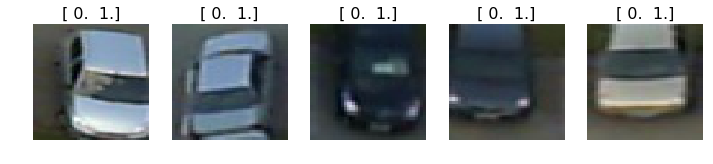

In [33]:
#sample batch data
batch_size = 5
batches = get_batches(path+'train', batch_size=batch_size)
imgs,labels = next(batches)
plots(imgs, titles=labels)

In [34]:
#predictions sample batch data
pred_batch(model,classes,imgs)

Shape: (5, 2)
Classes: ['empty', 'occupied']
Probabilities: [ 0.3186  0.6814]

Predictions prob/class: 
  0.6814/occupied
  0.7667/occupied
  0.7381/occupied
  0.7256/occupied
  0.7457/occupied


In [35]:
#finding predictions for sample test data
#Note: this takes average time = no of test images*0.01secs
start_time = time.time()
print(start_time)
#get the test batches and remove class label
test_batches = get_batches(path+'test', shuffle=False, batch_size=batch_size, class_mode=None)
#generate the probobailty of belonging to a class
val_batches, probs = test_batches, model.predict_generator(test_batches, int(np.ceil(test_batches.samples/batch_size)))
print((time.time() - start_time),'s')

1509272650.843327
Found 40 images belonging to 2 classes.
0.8322262763977051 s


In [36]:
print("time per image" , ((time.time() - start_time)/len(probs)))

time per image 0.020924675464630126


[[ 0 20]
 [ 0 20]]
error:  50.0


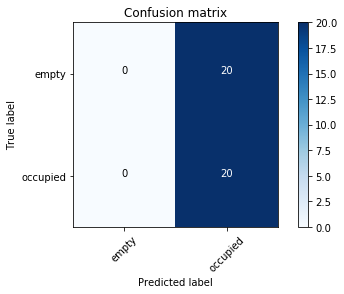

In [37]:
#computing confustion matrix

our_predictions = probs[:,0]
our_labels = np.round(1-our_predictions)

expected_labels = val_batches.classes

cm = confusion_matrix(expected_labels, our_labels)
plot_confusion_matrix(cm, val_batches.class_indices)

In [38]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 224, 224)       0         
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 3, 226, 226)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 64, 224, 224)      1792      
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 64, 226, 226)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 224, 224)      36928     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 64, 112, 112)      0         
_________________________________________________________________
zero_padding2d_16 (ZeroPaddi (None, 64, 114, 114)      0         
__________

In [39]:
#code to beep when code ends
"""
import winsound
frequency = 200  # Set Frequency To 2500 Hertz
duration = 500  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)
"""

'\nimport winsound\nfrequency = 200  # Set Frequency To 2500 Hertz\nduration = 500  # Set Duration To 1000 ms == 1 second\nwinsound.Beep(frequency, duration)\n'

# References

In [40]:
# -*- coding: utf-8 -*-
# Reference:
"""
Han S, Mao H, Dally WJ. Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding. arXiv preprint arXiv:1510.00149. 2015 Oct 1.
Jia Y. Caffe model zoo.
Course.fast.ai. (2017). Deep Learning For Coders. [online] Available at: http://course.fast.ai/ [Accessed 26 Oct. 2017].
Cs231n.stanford.edu. (2017). Stanford University CS231n: Convolutional Neural Networks for Visual Recognition. [online] Available at: http://cs231n.stanford.edu/ [Accessed 27 Oct. 2017].
François Chollet, https://github.com/fchollet/deep-learning-models
François Chollet, https://github.com/fchollet/deep-learning-models
"""

'\nHan S, Mao H, Dally WJ. Deep compression: Compressing deep neural networks with pruning, trained quantization and huffman coding. arXiv preprint arXiv:1510.00149. 2015 Oct 1.\nJia Y. Caffe model zoo.\nCourse.fast.ai. (2017). Deep Learning For Coders. [online] Available at: http://course.fast.ai/ [Accessed 26 Oct. 2017].\nCs231n.stanford.edu. (2017). Stanford University CS231n: Convolutional Neural Networks for Visual Recognition. [online] Available at: http://cs231n.stanford.edu/ [Accessed 27 Oct. 2017].\nFrançois Chollet, https://github.com/fchollet/deep-learning-models\nFrançois Chollet, https://github.com/fchollet/deep-learning-models\n'